In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.integrate import quad

In [2]:
img = cv2.imread("-47,90.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
H, W = img.shape[:2]
center_x, center_y = W // 2, H // 2
center = np.array([center_x, center_y])

In [3]:
'''
points = [
    {"name": "red",    "pixel": (146, 451), "lat": -58.760, "lon": 101.338,  "color": (255, 0, 0)},
    {"name": "green",  "pixel": (89, 200),  "lat": -52.708, "lon": 75.515,  "color": (0, 255, 0)},
    {"name": "blue",   "pixel": (414, 73),  "lat": -32.030, "lon": 85.221, "color": (0, 0, 255)},
]
'''
points = [
    {"name": "red",    "pixel": (146, 451), "lat": -58.668, "lon": 76.997,  "color": (255, 0, 0)},
    {"name": "green",  "pixel": (89, 200),  "lat": -42.734, "lon": 75.612,  "color": (0, 255, 0)},
    {"name": "blue",   "pixel": (414, 73),  "lat": -34.682, "lon": 102.153, "color": (0, 0, 255)},
]

In [4]:
distances1 = []

for pt in points:
    dist = np.linalg.norm(np.array(pt["pixel"]) - center)
    distances1.append(dist)

min_index = np.argmin(distances1)
main_point = points[min_index]

x_main, y_main = main_point["pixel"]

assistant_points = [pt for i, pt in enumerate(points) if i != min_index]

if len(assistant_points) < 2:
    raise ValueError("En az iki assistant point gerekiyor.")

assistant_points_sorted = sorted(
    assistant_points,
    key=lambda pt: float(np.linalg.norm(np.array(pt["pixel"]) - center))
)

ast1, ast2 = assistant_points_sorted[:2]

x_ast1, y_ast1 = ast1["pixel"]
x_ast2, y_ast2 = ast2["pixel"]

main_point["role"] = "main"
ast1["role"] = "assistant1"
ast2["role"] = "assistant2"

print("Main:", main_point)
print("Assistant1:", ast1)
print("Assistant2:", ast2)


Main: {'name': 'green', 'pixel': (89, 200), 'lat': -42.734, 'lon': 75.612, 'color': (0, 255, 0), 'role': 'main'}
Assistant1: {'name': 'red', 'pixel': (146, 451), 'lat': -58.668, 'lon': 76.997, 'color': (255, 0, 0), 'role': 'assistant1'}
Assistant2: {'name': 'blue', 'pixel': (414, 73), 'lat': -34.682, 'lon': 102.153, 'color': (0, 0, 255), 'role': 'assistant2'}


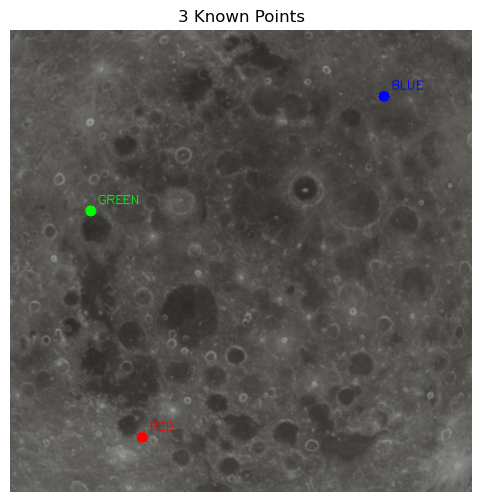

In [5]:
img_annotated1 = img.copy()

for pt in points:
    x, y = pt["pixel"]
    cv2.circle(img_annotated1, (x, y), radius=6, color=pt["color"], thickness=-1)
    label = f"{pt['name'].upper()}\n({pt['lat']:.3f}, {pt['lon']:.3f})"
    cv2.putText(img_annotated1, pt["name"].upper(), (x + 8, y - 8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, pt["color"], 1)

plt.figure(figsize=(6, 6))
plt.imshow(img_annotated1)
plt.title("3 Known Points")
plt.axis('off')
plt.show()

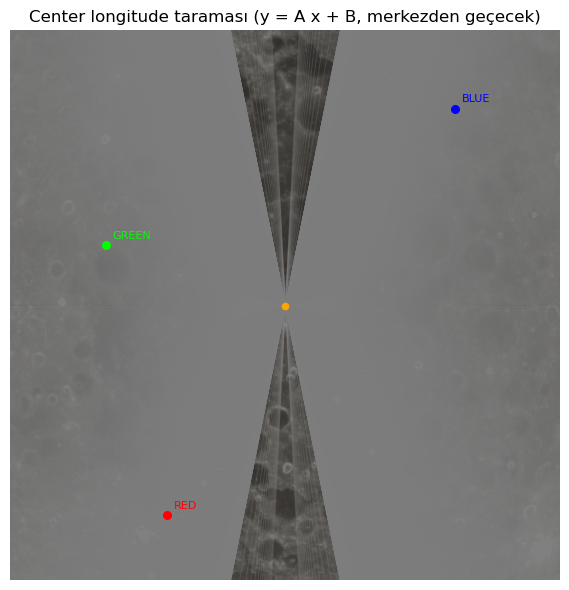

      A       B          x1   y1          x2     y2
0 -20.0  5376.0  268.800000  0.0  243.250000  511.0
1 -19.0  5120.0  269.473684  0.0  242.578947  511.0
2 -18.0  4864.0  270.222222  0.0  241.833333  511.0
3 -17.0  4608.0  271.058824  0.0  241.000000  511.0
4 -16.0  4352.0  272.000000  0.0  240.062500  511.0


In [6]:
A_vals = np.concatenate([
    np.arange(-20, -5, 1.0),
    np.arange(-5,  5.0001, 0.001),
    np.arange( 6,  21, 1.0)
])

def segment_through_center_from_A(A, cx, cy, W, H):
    B = cy - A*cx
    candidates = []

    y_left = A*0 + B
    if 0 <= y_left <= H-1:
        candidates.append((0.0, float(y_left)))

    x_r = W - 1
    y_right = A*x_r + B
    if 0 <= y_right <= H-1:
        candidates.append((float(x_r), float(y_right)))

    if A != 0:
        x_top = (0 - B)/A
        if 0 <= x_top <= W-1:
            candidates.append((float(x_top), 0.0))

        y_b = H - 1
        x_bottom = (y_b - B)/A
        if 0 <= x_bottom <= W-1:
            candidates.append((float(x_bottom), float(y_b)))

    uniq = []
    for p in candidates:
        if not any(abs(p[0]-q[0]) < 1e-6 and abs(p[1]-q[1]) < 1e-6 for q in uniq):
            uniq.append(p)
    if len(uniq) < 2:
        return None, None, B 
    return uniq[0], uniq[1], B

fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(img)
ax.set_xlim(0, W-1)
ax.set_ylim(H-1, 0)  
ax.set_title("Center longitude taraması (y = A x + B, merkezden geçecek)")
ax.axis('off')

for pt in points:
    x, y = pt["pixel"]
    ax.scatter([x], [y], s=30, color=np.array(pt["color"])/255.0, zorder=3)
    ax.text(x+6, y-6, pt["name"].upper(), fontsize=8, color=np.array(pt["color"])/255.0, zorder=3)

ax.scatter([center_x], [center_y], s=20, c='orange', zorder=4)

line_records = [] 
for A in A_vals:
    (p1, p2, B) = segment_through_center_from_A(A, center_x, center_y, W, H)
    if p1 is None or p2 is None:
        continue
    x1, y1 = p1
    x2, y2 = p2

    if abs(A) < 1e-12:
        ax.plot([x1, x2], [y1, y2], lw=2.0, color='orange', label='center longitude (A=0)', zorder=2)
    else:
        ax.plot([x1, x2], [y1, y2], lw=0.8, color='0.5', alpha=0.25, zorder=1)

    line_records.append({
        "A": float(A), "B": float(B),
        "x1": float(x1), "y1": float(y1),
        "x2": float(x2), "y2": float(y2)
    })

handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

lines_df = pd.DataFrame(line_records)
print(lines_df.head())


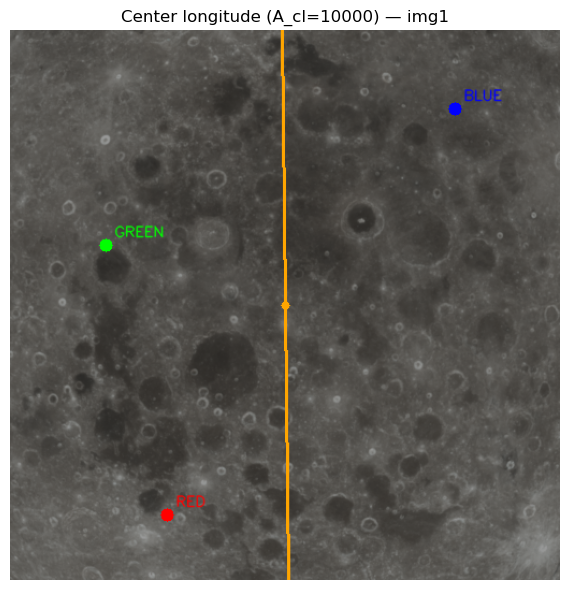

   A_cl    B_cl          x1   y1          x2     y2
0 -20.0  5376.0  268.800000  0.0  243.250000  511.0
1 -19.0  5120.0  269.473684  0.0  242.578947  511.0
2 -18.0  4864.0  270.222222  0.0  241.833333  511.0
3 -17.0  4608.0  271.058824  0.0  241.000000  511.0
4 -16.0  4352.0  272.000000  0.0  240.062500  511.0
img1 değişkeni RAM'de hazır. Dosya olarak da 'img1.png' kaydedildi.


In [7]:
A_vals = np.concatenate([
    np.arange(-20, -5, 1.0),
    np.arange(-5,   5.0001, 0.001),
    np.arange( 6, 21, 1.0)
])

def segment_through_center_from_A_cl(A_cl, cx, cy, W, H):
    B_cl = cy - A_cl * cx
    candidates = []

    y_left = B_cl
    if 0 <= y_left <= H - 1:
        candidates.append((0.0, float(y_left)))

    x_r = W - 1
    y_right = A_cl * x_r + B_cl
    if 0 <= y_right <= H - 1:
        candidates.append((float(x_r), float(y_right)))

    if abs(A_cl) > 1e-12:
        x_top = (0 - B_cl) / A_cl
        if 0 <= x_top <= W - 1:
            candidates.append((float(x_top), 0.0))

        y_b = H - 1
        x_bottom = (y_b - B_cl) / A_cl
        if 0 <= x_bottom <= W - 1:
            candidates.append((float(x_bottom), float(y_b)))

    uniq = []
    for p in candidates:
        if not any(abs(p[0]-q[0]) < 1e-6 and abs(p[1]-q[1]) < 1e-6 for q in uniq):
            uniq.append(p)
    if len(uniq) < 2:
        return None, None, B_cl
    return uniq[0], uniq[1], B_cl

line_records = []
for A_cl in A_vals:
    p1, p2, B_cl = segment_through_center_from_A_cl(A_cl, center_x, center_y, W, H)
    if p1 is None or p2 is None:
        continue
    x1, y1 = p1
    x2, y2 = p2
    line_records.append({
        "A_cl": float(A_cl), "B_cl": float(B_cl),
        "x1": float(x1), "y1": float(y1),
        "x2": float(x2), "y2": float(y2)
    })

A_cl_target = 100.0
B_cl_target = center_y - A_cl_target * center_x
p1_t, p2_t, _ = segment_through_center_from_A_cl(A_cl_target, center_x, center_y, W, H)

img1 = img.copy()

for pt in points:
    x, y = pt["pixel"]
    cv2.circle(img1, (int(x), int(y)), radius=6, color=pt["color"], thickness=-1)
    cv2.putText(img1, pt["name"].upper(), (int(x)+8, int(y)-8),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, pt["color"], 1, lineType=cv2.LINE_AA)

cv2.circle(img1, (int(center_x), int(center_y)), radius=4, color=(255,165,0), thickness=-1)

if p1_t is not None and p2_t is not None:
    x1_t, y1_t = map(int, map(round, p1_t))
    x2_t, y2_t = map(int, map(round, p2_t))
    cv2.line(img1, (x1_t, y1_t), (x2_t, y2_t), color=(255,165,0), thickness=2)

plt.figure(figsize=(6,6))
plt.imshow(img1)
plt.title("Center longitude (A_cl=10000) — img1")
plt.axis('off')
plt.tight_layout()
plt.show()

cv2.imwrite("img1.png", cv2.cvtColor(img1, cv2.COLOR_RGB2BGR))

lines_df = pd.DataFrame(line_records)
print(lines_df.head())

print("img1 değişkeni RAM'de hazır. Dosya olarak da 'img1.png' kaydedildi.")


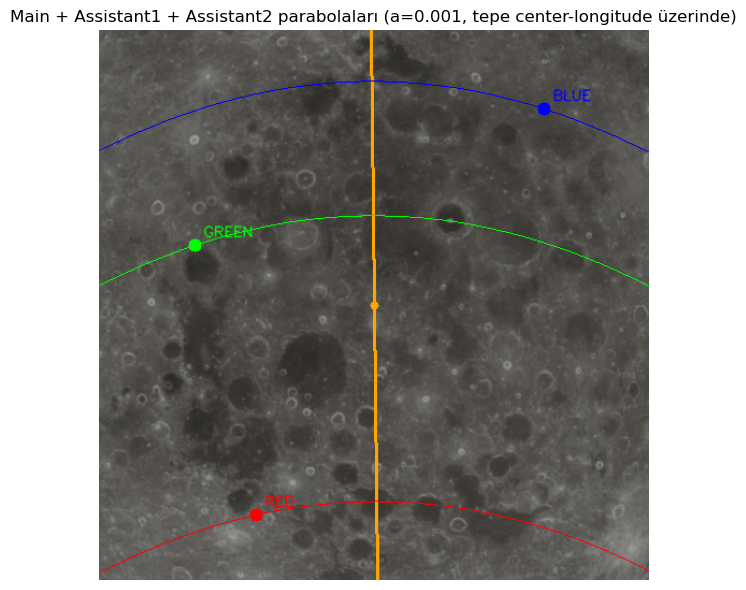

In [8]:
img2 = img1.copy()
a = 0.001

m = A_cl_target if 'A_cl_target' in locals() else 100.0
b = B_cl_target if 'B_cl_target' in locals() else (center_y - m*center_x)

def solve_vertex_r(x0, y0, m, b, a, W, H, prefer_x=center_x):
    """
    a*r^2 + (-2*a*x0 + m)*r + (a*x0^2 + b - y0) = 0 denklemini r için çözer.
    Gerçek köklerden görüntü içinde olanı; yoksa merkeze en yakın olanı seçer.
    """
    A = a
    B = -2*a*x0 + m
    C = a*(x0**2) + b - y0
    roots = np.roots([A, B, C])
    r_real = [r.real for r in roots if abs(r.imag) < 1e-9]
    if not r_real:
        return None, None
    in_range = [r for r in r_real if 0 <= r <= W-1]
    r = min(in_range, key=lambda R: abs(R - prefer_x)) if in_range else min(r_real, key=lambda R: abs(R - prefer_x))
    k = m*r + b
    return float(r), float(k)

triples = [
    ("main", main_point),
    ("assistant1", ast1),
    ("assistant2", ast2),
]

for label, pt in triples:
    x0, y0 = pt["pixel"]
    r, k = solve_vertex_r(x0, y0, m, b, a, W, H)
    if r is None:
        print(f"{label}: uygun kök bulunamadı, çizilmedi.")
        continue

    x_vals = np.arange(0, W)
    y_vals = a*(x_vals - r)**2 + k

    mask = (y_vals >= 0) & (y_vals < H)
    x_i = x_vals[mask].astype(int)
    y_i = np.round(y_vals[mask]).astype(int)

    col = tuple(int(c) for c in pt["color"]) 
    img2[y_i, x_i] = col

plt.figure(figsize=(6, 6))
plt.imshow(img2)
plt.title("Main + Assistant1 + Assistant2 parabolaları (a=0.001, tepe center-longitude üzerinde)")
plt.axis('off')
plt.tight_layout()
plt.show()


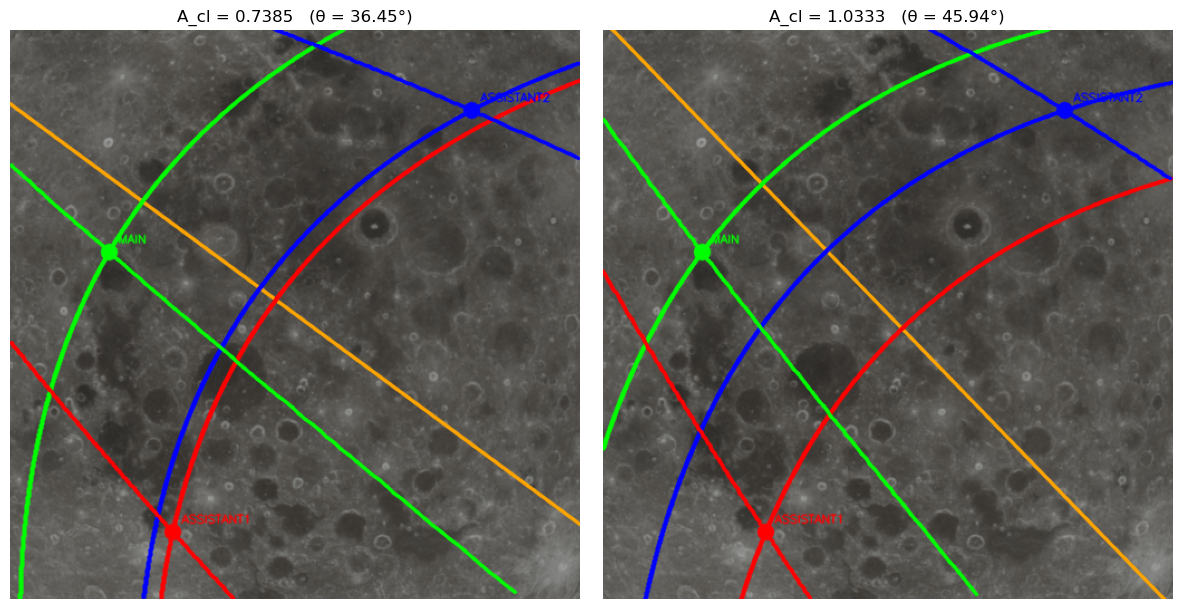

In [74]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

def segment_through_center_from_A_cl(A_cl, cx, cy, W, H):

    B_cl = cy - A_cl * cx
    cand = []

    y_left = B_cl
    if 0 <= y_left <= H - 1:
        cand.append((0.0, float(y_left)))

    xr = W - 1
    y_right = A_cl * xr + B_cl
    if 0 <= y_right <= H - 1:
        cand.append((float(xr), float(y_right)))

    if abs(A_cl) > 1e-12:
        x_top = (0 - B_cl) / A_cl
        if 0 <= x_top <= W - 1:
            cand.append((float(x_top), 0.0))
        yb = H - 1
        x_bottom = (yb - B_cl) / A_cl
        if 0 <= x_bottom <= W - 1:
            cand.append((float(x_bottom), float(yb)))

    uniq = []
    for p in cand:
        if not any(abs(p[0]-q[0]) < 1e-6 and abs(p[1]-q[1]) < 1e-6 for q in uniq):
            uniq.append(p)
    if len(uniq) < 2:
        return None, None, B_cl
    return uniq[0], uniq[1], B_cl

def rotated_parabola_points(P, m, C, a, W, H, t_step=0.5):
    P = np.array(P, dtype=float); C = np.array(C, dtype=float)
    norm = np.hypot(1.0, m) if np.isfinite(m) else 1.0
    u = np.array([1.0, m]) / norm
    v = np.array([-m, 1.0]) / norm
    d = P - C
    t0 = v @ d
    n0 = u @ d
    s  = n0 - a*(t0**2)
    V  = C + s*u
    T = max(W, H) * 1.5
    t_vals = np.arange(-T, T+t_step, t_step)
    pts = V[None,:] + t_vals[:,None]*v[None,:] + (a*(t_vals**2))[:,None]*u[None,:]
    xs, ys = pts[:,0], pts[:,1]
    mask = (xs >= 0) & (xs <= W-1) & (ys >= 0) & (ys <= H-1)
    return xs[mask], ys[mask], V

def rotated_parabola_points_fixed_vertex(P, m, V, W, H, t_step=0.5):
    P = np.array(P, dtype=float); V = np.array(V, dtype=float)
    norm = np.hypot(1.0, m) if np.isfinite(m) else 1.0
    u = np.array([1.0, m]) / norm
    v = np.array([-m, 1.0]) / norm

    d = P - V
    t = float(v @ d)      
    if abs(t) < 1e-9:
        t = 1e-3
    n = float(u @ d)
    a = n / (t**2)

    T = 2.0 * max(W, H)
    if t > 0:
        t_vals = np.arange(0.0,  T + t_step,  t_step)
    else:
        t_vals = np.arange(0.0, -T - t_step, -t_step)

    pts = V[None,:] + t_vals[:,None]*v[None,:] + (a*(t_vals**2))[:,None]*u[None,:]
    xs, ys = pts[:,0], pts[:,1]
    mask = (xs >= 0) & (xs <= W-1) & (ys >= 0) & (ys <= H-1)
    return xs[mask], ys[mask], V

def draw_parabola_on_image(img_rgb, xs, ys, color_rgb, thickness=2):
    if xs.size < 2: return
    xi = np.round(xs).astype(int)
    yi = np.round(ys).astype(int)
    H, W = img_rgb.shape[:2]
    mask = (xi>=0)&(xi<W)&(yi>=0)&(yi<H)
    xi, yi = xi[mask], yi[mask]
    if xi.size < 2: return
    pts = np.vstack([xi, yi]).T.reshape(-1,1,2)
    cv2.polylines(img_rgb, [pts], isClosed=False,
                  color=tuple(int(c) for c in color_rgb), thickness=thickness,
                  lineType=cv2.LINE_AA)

def draw_point_with_label(img_rgb, xy, text, color_rgb):
    H, W = img_rgb.shape[:2]
    x, y = int(xy[0]), int(xy[1])
    RADIUS     = max(6, int(0.014 * min(W, H)))
    LABEL_OFF  = max(8, int(0.015 * min(W, H)))
    FONT_SCALE = max(0.35, 0.018 * min(W, H) / 100.0)
    THICK_TEXT = 1
    cv2.circle(img_rgb, (x, y), RADIUS, tuple(int(c) for c in color_rgb),
               thickness=-1, lineType=cv2.LINE_AA)
    org = (x + LABEL_OFF, y - LABEL_OFF)
    cv2.putText(img_rgb, text, org, cv2.FONT_HERSHEY_SIMPLEX, FONT_SCALE,
                tuple(int(c) for c in color_rgb), THICK_TEXT, cv2.LINE_AA)


H, W = img.shape[:2]
Cxy = (float(center_x), float(center_y))

rng = np.random.default_rng()
A_candidates = rng.uniform(-1.2, 1.2, size=2)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
a_lat = 0.001     
OFFSET_FRAC = 1.0   

for ax, m in zip(axes, A_candidates):
    img2 = img.copy()

    p1, p2, _ = segment_through_center_from_A_cl(m, Cxy[0], Cxy[1], W, H)
    if p1 is not None and p2 is not None:
        x1, y1 = map(int, map(round, p1))
        x2, y2 = map(int, map(round, p2))
        cv2.line(img2, (x1, y1), (x2, y2), color=(255, 165, 0), thickness=2, lineType=cv2.LINE_AA)

    for pt in (main_point, ast1, ast2):
        xs, ys, _ = rotated_parabola_points(pt["pixel"], m, np.array(Cxy), a_lat, W, H, t_step=0.5)
        draw_parabola_on_image(img2, xs, ys, color_rgb=pt["color"], thickness=2)

    norm_m = math.hypot(1.0, m) if math.isfinite(m) else 1.0
    u = np.array([1.0, m], dtype=float) / norm_m
    sign_dir = np.sign((np.array(main_point["pixel"], float) - np.array(Cxy, float)) @ u)
    if sign_dir == 0: sign_dir = 1.0
    V_common = np.array(Cxy, float) + sign_dir * (OFFSET_FRAC * min(W, H)) * u

    for pt in (main_point, ast1, ast2):
        xs, ys, _ = rotated_parabola_points_fixed_vertex(pt["pixel"], m, V_common, W, H, t_step=0.5)
        draw_parabola_on_image(img2, xs, ys, color_rgb=pt["color"], thickness=2)

    for pt in (main_point, ast1, ast2):
        draw_point_with_label(
            img2, pt["pixel"],
            (pt.get("role") or pt.get("name","")).upper(),
            pt["color"]
        )

    theta_deg = math.degrees(math.atan(m))
    ax.imshow(img2)
    ax.set_title(f"A_cl = {m:.4f}   (θ = {theta_deg:.2f}°)")
    ax.set_xlim(0, W-1); ax.set_ylim(H-1, 0)
    ax.axis('off')

plt.tight_layout()
plt.show()


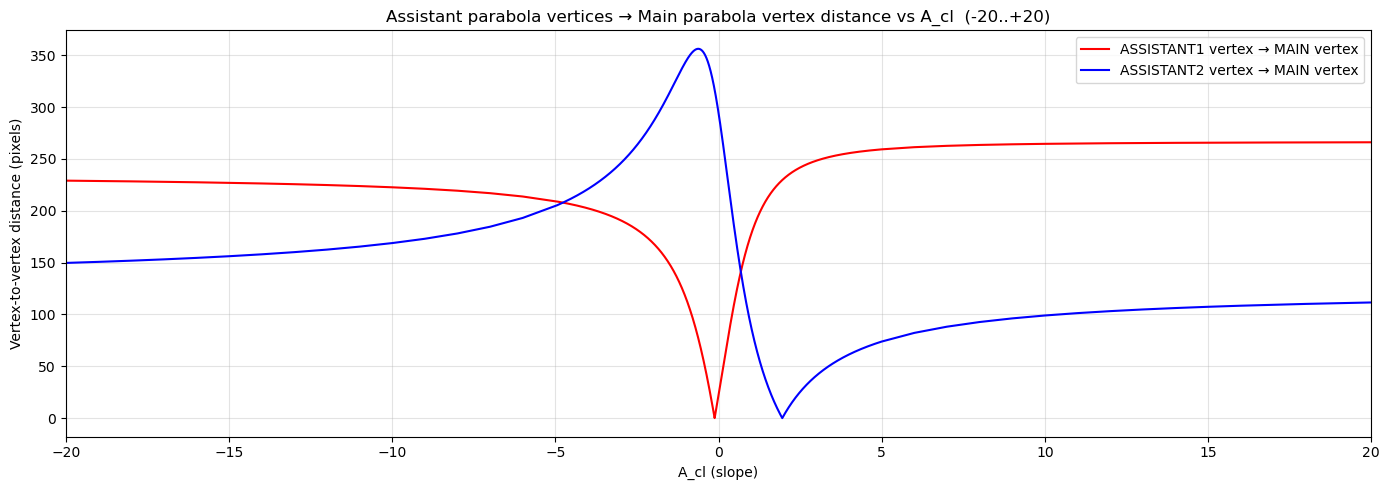

In [60]:
a = 0.001
C = np.array([center_x, center_y], dtype=float)

A_vals = np.concatenate([
    np.arange(-20, -5, 1.0),
    np.arange( -5,  5.0001, 0.001),
    np.arange(  6, 20+1, 1.0)
])

def vertex_rotated(P, m, C, a):
    P = np.asarray(P, dtype=float)
    C = np.asarray(C, dtype=float)
    norm = np.hypot(1.0, m)
    u = np.array([1.0, m]) / norm          
    v = np.array([-m, 1.0]) / norm          
    delta = P - C
    t0 = v.dot(delta)
    n0 = u.dot(delta)
    s  = n0 - a*(t0**2)
    V  = C + s*u                             
    return V


p_main = np.array(main_point["pixel"], dtype=float)
p_ast1 = np.array(ast1["pixel"],       dtype=float)
p_ast2 = np.array(ast2["pixel"],       dtype=float)


d_ast1, d_ast2 = [], []
for m in A_vals:
    V_main = vertex_rotated(p_main, m, C, a)
    V_a1   = vertex_rotated(p_ast1, m, C, a)
    V_a2   = vertex_rotated(p_ast2, m, C, a)
    d_ast1.append(np.linalg.norm(V_a1 - V_main))
    d_ast2.append(np.linalg.norm(V_a2 - V_main))

d_ast1 = np.array(d_ast1)
d_ast2 = np.array(d_ast2)


c1 = np.array(ast1["color"])/255.0
c2 = np.array(ast2["color"])/255.0
n0 = main_point.get("role", main_point["name"]).upper()
n1 = ast1.get("role", ast1["name"]).upper()
n2 = ast2.get("role", ast2["name"]).upper()

plt.figure(figsize=(14,5))
plt.plot(A_vals, d_ast1, label=f"{n1} vertex → {n0} vertex", color=c1)
plt.plot(A_vals, d_ast2, label=f"{n2} vertex → {n0} vertex", color=c2)
plt.xlim([-20, 20])
plt.xlabel("A_cl (slope)")
plt.ylabel("Vertex-to-vertex distance (pixels)")
plt.title("Assistant parabola vertices → Main parabola vertex distance vs A_cl  (-20..+20)")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


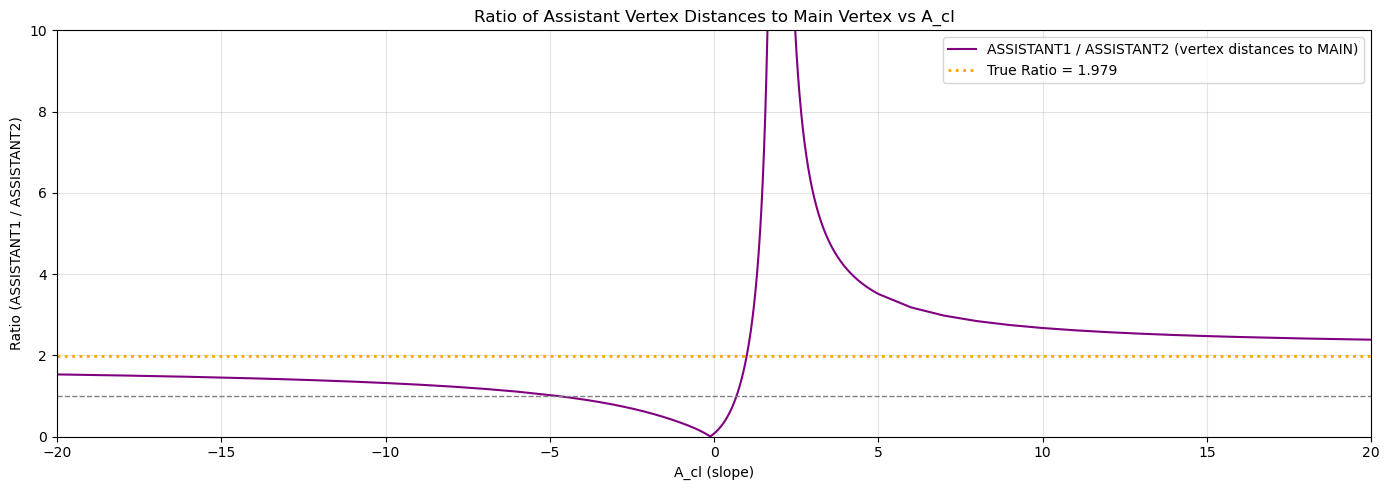

In [42]:
A_vals = np.concatenate([
    np.arange(-20, -5, 1.0),
    np.arange( -5,  5.0001, 0.001),
    np.arange(  6, 20+1, 1.0)
])

a = 0.001
C = np.array([center_x, center_y], dtype=float)

if 'vertex_rotated' not in globals():
    def vertex_rotated(P, m, C, a):
        P = np.asarray(P, dtype=float); C = np.asarray(C, dtype=float)
        norm = np.hypot(1.0, m)
        u = np.array([1.0, m]) / norm     
        v = np.array([-m, 1.0]) / norm     
        delta = P - C
        t0 = v.dot(delta)
        n0 = u.dot(delta)
        s  = n0 - a*(t0**2)
        V  = C + s*u
        return V

p_main = np.array(main_point["pixel"], dtype=float)
p_ast1 = np.array(ast1["pixel"],       dtype=float)
p_ast2 = np.array(ast2["pixel"],       dtype=float)

d1_list, d2_list = [], []

for m in A_vals:
    V_main = vertex_rotated(p_main, m, C, a)
    V_a1   = vertex_rotated(p_ast1, m, C, a)
    V_a2   = vertex_rotated(p_ast2, m, C, a)
    d1_list.append(np.linalg.norm(V_a1 - V_main))
    d2_list.append(np.linalg.norm(V_a2 - V_main))

d1 = np.array(d1_list)
d2 = np.array(d2_list)

ratio = np.divide(d1, d2, out=np.full_like(d1, np.nan), where=(d2!=0))

n0 = main_point.get("role", main_point["name"]).upper()
n1 = ast1.get("role", ast1["name"]).upper()
n2 = ast2.get("role", ast2["name"]).upper()

plt.figure(figsize=(14,5))
plt.plot(A_vals, ratio, color='purple', label=f"{n1} / {n2} (vertex distances to {n0})")
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)

if 'real_lat_ratio' in globals():
    plt.axhline(real_lat_ratio, color='orange', linestyle=':', linewidth=2, label=f"True Ratio = {real_lat_ratio:.3f}")

plt.xlim([-20, 20])
plt.ylim(0, 10)  
plt.xlabel("A_cl (slope)")
plt.ylabel(f"Ratio ({n1} / {n2})")
plt.title("Ratio of Assistant Vertex Distances to Main Vertex vs A_cl")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


Real Distances Between Latitudes of 3 Points:

Distance from GREEN to RED: 483.06 km
Distance from GREEN to BLUE: 244.11 km

Real latitude ratio (assistant1/assistant2): 1.9789


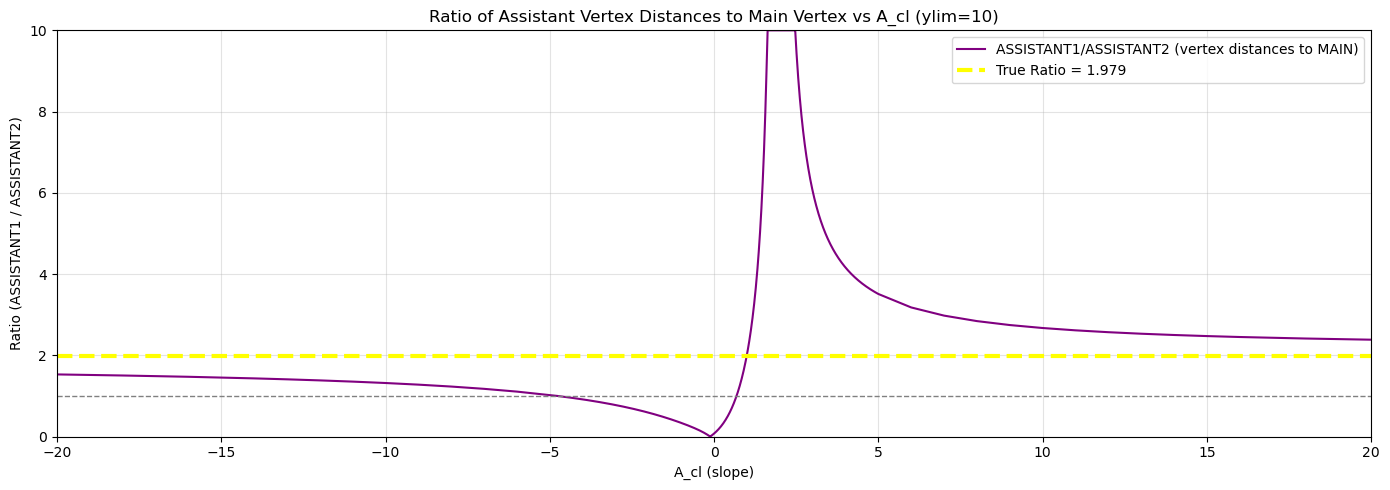

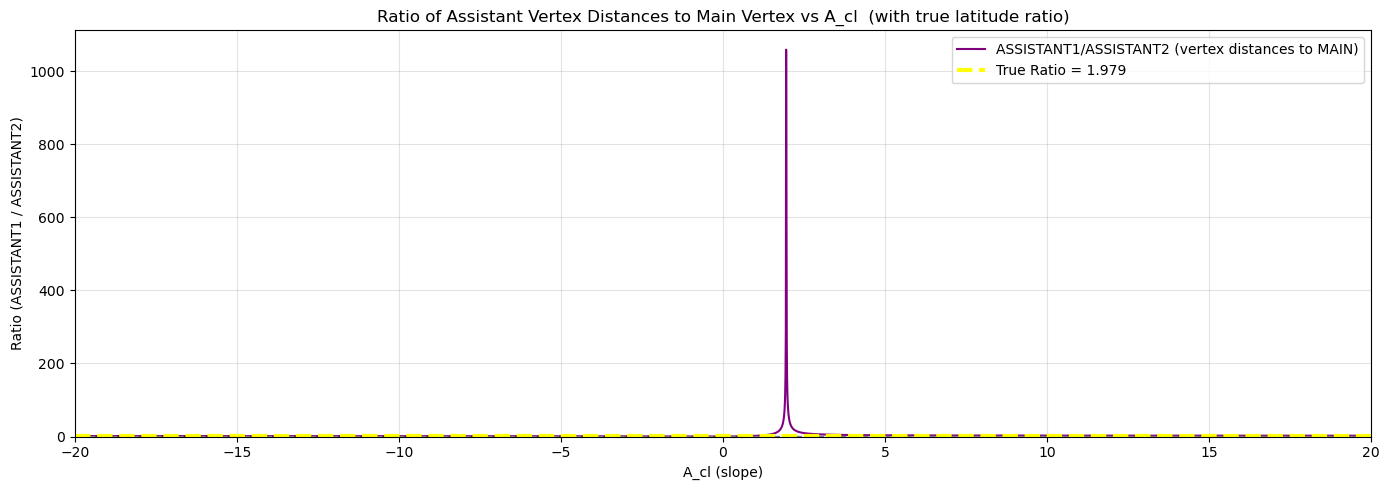

In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt

moon_radius_km = 1737.0

main_lat = float(main_point["lat"])
ast1_lat = float(ast1["lat"])
ast2_lat = float(ast2["lat"])

def lat_arc_km(phi1_deg, phi2_deg, R=moon_radius_km):
    return abs(math.radians(phi1_deg - phi2_deg)) * R

d1_lat = lat_arc_km(main_lat, ast1_lat)  
d2_lat = lat_arc_km(main_lat, ast2_lat)
real_lat_ratio = d1_lat / d2_lat if d2_lat != 0 else np.nan

print("Real Distances Between Latitudes of 3 Points:\n")
print(f"Distance from {main_point['name'].upper()} to {ast1['name'].upper()}: {d1_lat:.2f} km")
print(f"Distance from {main_point['name'].upper()} to {ast2['name'].upper()}: {d2_lat:.2f} km")
print("\nReal latitude ratio (assistant1/assistant2): {:.4f}".format(real_lat_ratio))

A_vals = np.concatenate([
    np.arange(-20, -5, 1.0),
    np.arange( -5,  5.0001, 0.01),
    np.arange(  6,  21, 1.0)
])

a = 0.001
C = np.array([center_x, center_y], dtype=float)

def vertex_rotated(P, m, C, a):
    P = np.asarray(P, dtype=float); C = np.asarray(C, dtype=float)
    norm = np.hypot(1.0, m)
    u = np.array([1.0, m]) / norm   
    v = np.array([-m, 1.0]) / norm    
    d = P - C
    t0 = v.dot(d); n0 = u.dot(d)
    s  = n0 - a*(t0**2)
    return C + s*u                    

p_main = np.array(main_point["pixel"], dtype=float)
p_a1   = np.array(ast1["pixel"],       dtype=float)
p_a2   = np.array(ast2["pixel"],       dtype=float)

d1, d2 = [], []
for m in A_vals:
    V_main = vertex_rotated(p_main, m, C, a)
    V_a1   = vertex_rotated(p_a1,   m, C, a)
    V_a2   = vertex_rotated(p_a2,   m, C, a)
    d1.append(np.linalg.norm(V_a1 - V_main))
    d2.append(np.linalg.norm(V_a2 - V_main))

d1 = np.array(d1); d2 = np.array(d2)
ratio = np.divide(d1, d2, out=np.full_like(d1, np.nan), where=(d2!=0))

ratio_capped = np.clip(ratio, 0, 10)  # 0–10 ile sınırla

plt.figure(figsize=(14,5))
plt.plot(A_vals, ratio_capped, color='purple',
         label=f"{n1}/{n2} (vertex distances to {n0})")
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)

if 'real_lat_ratio' in globals():
    plt.axhline(min(real_lat_ratio, 10), color='yellow', linestyle='--', linewidth=3,
                label=f"True Ratio = {real_lat_ratio:.3f}")

plt.xlim([-20, 20])
plt.ylim(0, 10)      
plt.xlabel("A_cl (slope)")
plt.ylabel(f"Ratio ({n1} / {n2})")
plt.title("Ratio of Assistant Vertex Distances to Main Vertex vs A_cl (ylim=10)")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


n0 = main_point.get("role", main_point["name"]).upper()
n1 = ast1.get("role", ast1["name"]).upper()
n2 = ast2.get("role", ast2["name"]).upper()

plt.figure(figsize=(14,5))
plt.plot(A_vals, ratio, color='purple', label=f"{n1}/{n2} (vertex distances to {n0})")
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.axhline(real_lat_ratio, color='yellow', linestyle='--', linewidth=3,
            label=f"True Ratio = {real_lat_ratio:.3f}") 

plt.xlim([-20, 20])
plt.ylim(bottom=0)  
plt.xlabel("A_cl (slope)")
plt.ylabel(f"Ratio ({n1} / {n2})")
plt.title("Ratio of Assistant Vertex Distances to Main Vertex vs A_cl  (with true latitude ratio)")
plt.grid(True, alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


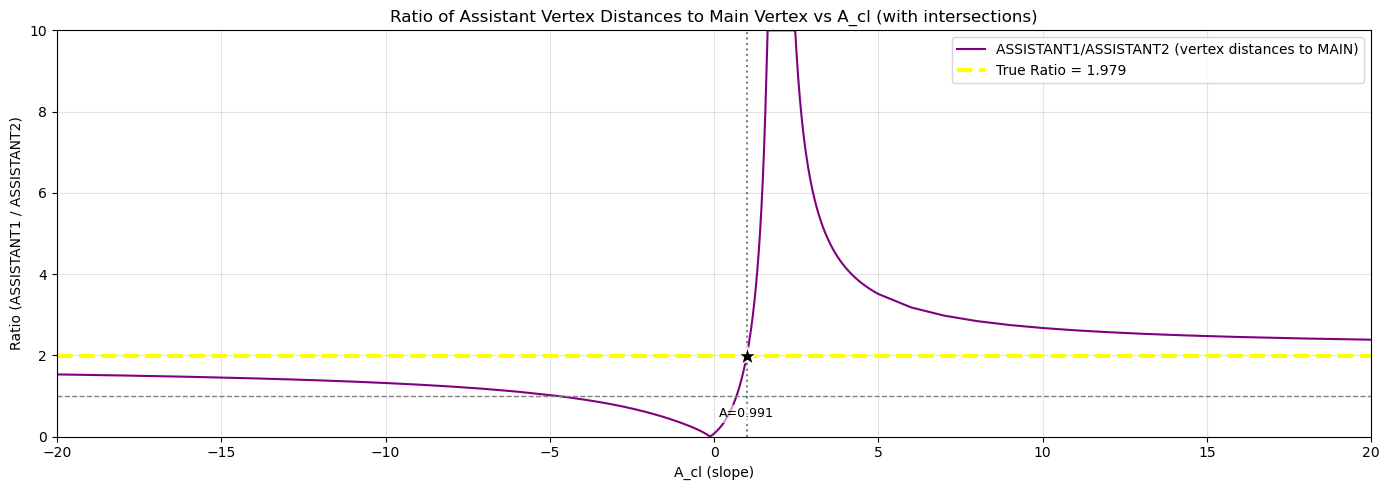

Kesişim A_cl değerleri: 0.991435


In [14]:
y_target = min(real_lat_ratio, 10.0)

A = A_vals.copy()
Y = ratio.copy() 
valid = np.isfinite(Y)
A = A[valid]; Y = Y[valid]

diff = Y - y_target

cross_idx = np.where(np.sign(diff[:-1]) * np.sign(diff[1:]) < 0)[0]

xstars = []
for i in cross_idx:
    x1, x2 = A[i], A[i+1]
    y1, y2 = Y[i], Y[i+1]
    x_cross = x1 + (x2 - x1) * (y_target - y1) / (y2 - y1) 
    xstars.append(float(x_cross))

eq_idx = np.where(np.isclose(diff, 0, atol=1e-6))[0]
for i in eq_idx:
    xstars.append(float(A[i]))

xstars = sorted(xstars)
xstars_unique = []
for x in xstars:
    if not xstars_unique or abs(x - xstars_unique[-1]) > 1e-3:
        xstars_unique.append(x)

ratio_capped = np.clip(ratio, 0, 10)

plt.figure(figsize=(14,5))
plt.plot(A_vals, ratio_capped, color='purple', label=f"{n1}/{n2} (vertex distances to {n0})")
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.axhline(y_target, color='yellow', linestyle='--', linewidth=3,
            label=f"True Ratio = {real_lat_ratio:.3f}")
plt.xlim([-20, 20])
plt.ylim(0, 10)
plt.xlabel("A_cl (slope)")
plt.ylabel(f"Ratio ({n1} / {n2})")
plt.title("Ratio of Assistant Vertex Distances to Main Vertex vs A_cl (with intersections)")
plt.grid(True, alpha=0.35)

y_star = y_target  
for x0 in xstars_unique:
    plt.plot(x0, y_star, marker='*', markersize=14, color='black',
             markeredgecolor='white', zorder=6)
    plt.axvline(x0, color='black', linestyle=':', alpha=0.5)
    plt.text(x0, 0.4, f"A={x0:.3f}", ha='center', va='bottom', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6, lw=0))

plt.legend()
plt.tight_layout()
plt.show()

if not xstars_unique:
    print("Uyarı: [-20,20] aralığında oran eğrisi ile referans çizgi kesişmiyor.")
else:
    print("Kesişim A_cl değerleri:", ", ".join(f"{x:.6f}" for x in xstars_unique))


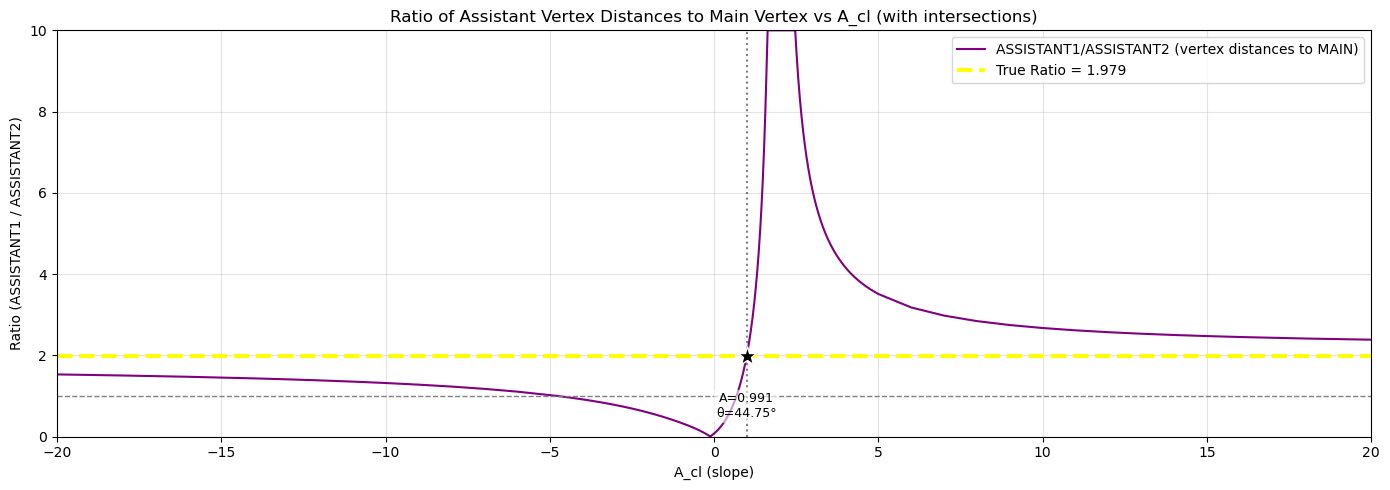

Kesişim A_cl değerleri: 0.991435
Kesişim açıları (atan(A_cl), derece): 44.753566°


In [15]:
import math

ratio_capped = np.clip(ratio, 0, 10)

plt.figure(figsize=(14,5))
plt.plot(A_vals, ratio_capped, color='purple', label=f"{n1}/{n2} (vertex distances to {n0})")
plt.axhline(1.0, color='gray', linestyle='--', linewidth=1)
plt.axhline(y_target, color='yellow', linestyle='--', linewidth=3,
            label=f"True Ratio = {real_lat_ratio:.3f}")
plt.xlim([-20, 20])
plt.ylim(0, 10)
plt.xlabel("A_cl (slope)")
plt.ylabel(f"Ratio ({n1} / {n2})")
plt.title("Ratio of Assistant Vertex Distances to Main Vertex vs A_cl (with intersections)")
plt.grid(True, alpha=0.35)

y_star = y_target 
for x0 in xstars_unique:
    theta_deg = math.degrees(math.atan(x0))  
    plt.plot(x0, y_star, marker='*', markersize=14, color='black',
             markeredgecolor='white', zorder=6)
    plt.axvline(x0, color='black', linestyle=':', alpha=0.5)
    # A ve açı bilgisini birlikte yaz
    plt.text(x0, 0.4, f"A={x0:.3f}\nθ={theta_deg:.2f}°",
             ha='center', va='bottom', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.6, lw=0))

plt.legend()
plt.tight_layout()
plt.show()

if not xstars_unique:
    print("Uyarı: [-20,20] aralığında oran eğrisi ile referans çizgi kesişmiyor.")
else:
    angles_deg = [math.degrees(math.atan(x)) for x in xstars_unique]
    print("Kesişim A_cl değerleri:", ", ".join(f"{x:.6f}" for x in xstars_unique))
    print("Kesişim açıları (atan(A_cl), derece):", ", ".join(f"{ang:.6f}°" for ang in angles_deg))


Uyarı: Sadece tek kesişim bulundu; ikinci panel boş kalacak.


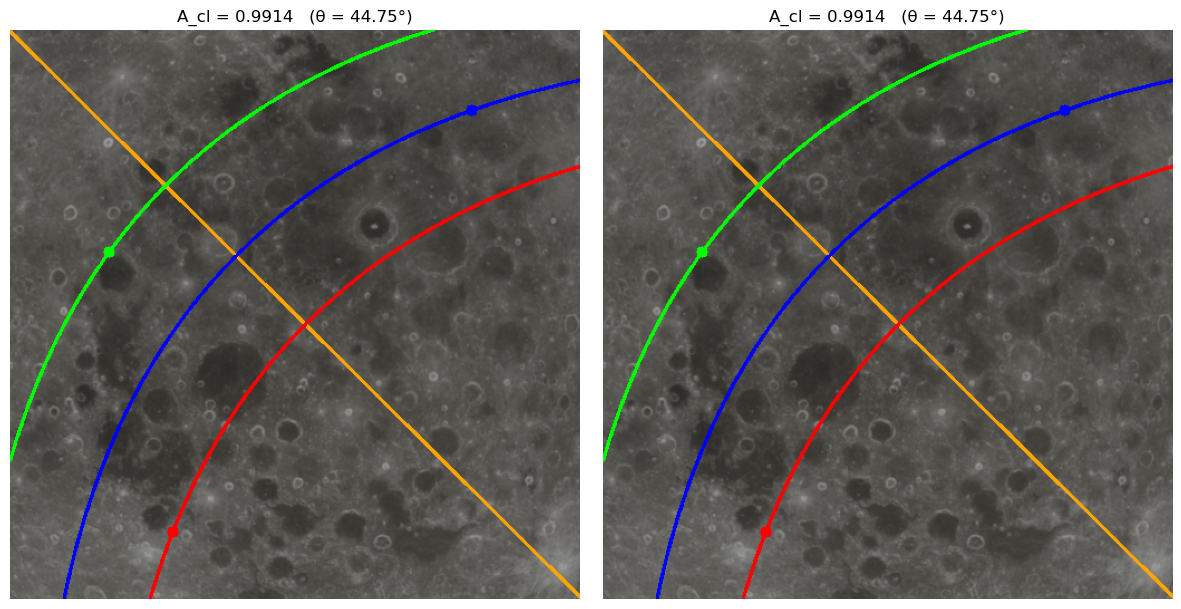

In [16]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

if 'segment_through_center_from_A_cl' not in globals():
    def segment_through_center_from_A_cl(A_cl, cx, cy, W, H):
        B_cl = cy - A_cl * cx
        cand = []
        # x=0
        y_left = B_cl
        if 0 <= y_left <= H - 1:
            cand.append((0.0, float(y_left)))
        # x=W-1
        xr = W - 1
        y_right = A_cl * xr + B_cl
        if 0 <= y_right <= H - 1:
            cand.append((float(xr), float(y_right)))
        # y=0 ve y=H-1
        if abs(A_cl) > 1e-12:
            x_top = (0 - B_cl) / A_cl
            if 0 <= x_top <= W - 1:
                cand.append((float(x_top), 0.0))
            yb = H - 1
            x_bottom = (yb - B_cl) / A_cl
            if 0 <= x_bottom <= W - 1:
                cand.append((float(x_bottom), float(yb)))
        uniq = []
        for p in cand:
            if not any(abs(p[0]-q[0]) < 1e-6 and abs(p[1]-q[1]) < 1e-6 for q in uniq):
                uniq.append(p)
        if len(uniq) < 2:
            return None, None, B_cl
        return uniq[0], uniq[1], B_cl

if 'rotated_parabola_points' not in globals():
    def rotated_parabola_points(P, m, C, a, W, H, t_step=0.5):
        P = np.array(P, dtype=float); C = np.array(C, dtype=float)
        norm = np.hypot(1.0, m) if np.isfinite(m) else 1.0
        u = np.array([1.0, m]) / norm
        v = np.array([-m, 1.0]) / norm
        d = P - C
        t0 = v @ d
        n0 = u @ d
        s  = n0 - a*(t0**2)
        V  = C + s*u
        T = max(W, H) * 1.5
        t_vals = np.arange(-T, T+t_step, t_step)
        pts = V[None,:] + t_vals[:,None]*v[None,:] + (a*(t_vals**2))[:,None]*u[None,:]
        xs, ys = pts[:,0], pts[:,1]
        mask = (xs >= 0) & (xs <= W-1) & (ys >= 0) & (ys <= H-1)
        return xs[mask], ys[mask], V

def draw_parabola_on_image(img_rgb, Pxy, m, Cxy, a, color_rgb, thickness=2):
    xs, ys, _ = rotated_parabola_points(Pxy, m, np.array(Cxy), a, W, H, t_step=0.5)
    if xs.size == 0:
        return
    xi = np.round(xs).astype(int)
    yi = np.round(ys).astype(int)
    mask = (xi>=0)&(xi<W)&(yi>=0)&(yi<H)
    xi, yi = xi[mask], yi[mask]
    if len(xi) < 2:
        return
    pts = np.vstack([xi, yi]).T.reshape(-1,1,2)
    cv2.polylines(img_rgb, [pts], isClosed=False, color=tuple(int(c) for c in color_rgb), thickness=thickness)

if len(xstars_unique) == 0:
    raise RuntimeError("Kesişim bulunamadı; önce xstars_unique listesini oluşturduğun hücreyi çalıştır.")
A_two = sorted(xstars_unique, key=lambda x: abs(x))[:2]
if len(A_two) < 2:
    print("Uyarı: Sadece tek kesişim bulundu; ikinci panel boş kalacak.")
    A_two = A_two + [A_two[0]] 

a = 0.001
Cxy = (center_x, center_y)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax, m in zip(axes, A_two):
    img2 = img.copy()

    p1, p2, _ = segment_through_center_from_A_cl(m, center_x, center_y, W, H)
    if p1 is not None and p2 is not None:
        x1, y1 = map(int, map(round, p1))
        x2, y2 = map(int, map(round, p2))
        cv2.line(img2, (x1,y1), (x2,y2), color=(255,165,0), thickness=2)  # turuncu

    draw_parabola_on_image(img2, main_point["pixel"], m, Cxy, a, color_rgb=main_point["color"], thickness=2)
    draw_parabola_on_image(img2, ast1["pixel"],     m, Cxy, a, color_rgb=ast1["color"],       thickness=2)
    draw_parabola_on_image(img2, ast2["pixel"],     m, Cxy, a, color_rgb=ast2["color"],       thickness=2)

    for pt in [main_point, ast1, ast2]:
        x,y = pt["pixel"]
        cv2.circle(img2, (int(x),int(y)), radius=5, color=tuple(int(c) for c in pt["color"]), thickness=-1)

    theta_deg = math.degrees(math.atan(m))
    ax.imshow(img2)
    ax.set_title(f"A_cl = {m:.4f}   (θ = {theta_deg:.2f}°)")
    ax.set_xlim(0, W-1); ax.set_ylim(H-1, 0)
    ax.axis('off')

plt.tight_layout()
plt.show()
